# K-Nearest Neighbors classifier for stroke prediction
### Import data

In [16]:
# Import data with our data_processing function
from data_processing import prepare_data, split_data
from helper_functions import get_metrics
import pandas as pd

# Make the data into a pd dataframe
df = prepare_data('healthcare-dataset-stroke-data.csv')

# Split the data into training, testing and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(df, (0.6, 0.2, 0.2))

In [17]:
def split_datatypes(data):
    
    numeric = ['age', "avg_glucose_level", "bmi"]
    binary = ['hypertension', 'heart_disease', 'children', 'residence_type', 
              'gender', 'never_worked', 'private', 'self-employed', 
              'govt_job', 'unknown_smoking_status', 'formerly_smoked', 'never_smoked', 'smokes']

    # Numeric data: age, avg_glucose_level, bmi 
    data_num = data.drop(columns=binary)
    
    # binary data: hypertension, heart_disease, marriage status, rural/urban
    data_bin = data.drop(columns=numeric)
    
    return data_num, data_bin

# split all data into numeric and binary data.
train_data_num, train_data_bin = split_datatypes(train_data)
test_data_num, test_data_bin = split_datatypes(test_data)
val_data_num, val_data_bin = split_datatypes(val_data)

train_data_num.head()

,age,avg_glucose_level,bmi
4708,1.557660,2.898686,0.611884
368,0.050155,0.047559,2.343591
2764,-0.836612,-0.444551,4.380894
4692,0.803907,-0.173733,0.102558
739,0.537877,-1.124634,-0.228504


## The K-Nearest Neighbor classification model


In [18]:
# K-Nearest Neighbour algorithm for classification of test data, with all data
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

# Model training:
def train_and_predict(training_data, training_labels, testing_data, testing_labels, 
                      nr_neighbors = "5", weight_metric = "uniform", metric='euclidean'):
    """
    This function trains a nearest neighbors classifier, with nr_neighbors as the neighbors used for classification and
    a weight metric given as input, standard with every neighbor having the same weight. It outputs the predictions for the 
    testing data.
    """
        
    # Make an instance of the k-NN model
    knn = KNeighborsClassifier(n_neighbors, weights=weight_metric, metric=metric) 

    # Fit the data to the model
    knn.fit(training_data, training_labels)

    # Predict the classes for the testing data
    predictions_train = knn.predict(training_data)
    predictions_test = knn.predict(testing_data)
    
    # Return predictions and accuracy on testing data
    return predictions_train, predictions_test

# Determine the amount of neighbours the algorithm will consider for the nearest neighbours classification
n_neighbors = 5

# predictions using model with all features in dataset and euclidean distance.
predictions_train, predictions_test = train_and_predict(train_data, train_labels, 
                                                         test_data, test_labels, 
                                                         n_neighbors, "distance", metric='euclidean')

# predictions using model with only categorical data in dataset and jaccard distance metric
predictions_train_bin, predictions_test_bin,  = train_and_predict(train_data_bin, train_labels, 
                                                         test_data_bin, test_labels, 
                                                         n_neighbors, "distance", metric='jaccard')

# predictions using model with only numerical data in dataset and euclidean distance metric
predictions_train_num, predictions_test_num,  = train_and_predict(train_data_num, train_labels, 
                                                         test_data_num, test_labels, 
                                                         n_neighbors, "distance", metric='euclidean')


# Get accuracy and balanced accuracy and print them.
print('predictions using numeric features:')
accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test_num, verbose=True)

print('predictions using categorical features:')
accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test_bin, verbose=True)

print('predictions using all features:')
accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test, verbose=True)






predictions using numeric features:
accuracy: 94.2974 % 

balanced accuracy: 50.6582 %
sensitivity: 0.0196078431372549
specificity: 0.9935553168635876 

confusion matrix: 
[[925   6]
 [ 50   1]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

predictions using categorical features:
accuracy: 94.8065 % 

balanced accuracy: 50.0000 %
sensitivity: 0.0
specificity: 1.0 

confusion matrix: 
[[931   0]
 [ 51   0]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

predictions using all features:
accuracy: 94.7047 % 

balanced accuracy: 50.8730 %
sensitivity: 0.0196078431372549
specificity: 0.9978517722878625 

confusion matrix: 
[[929   2]
 [ 50   1]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



### Actual model

##### Improvements
1. combine predictions from numerical and categorical models

In [19]:
# Combined prediction (if any of both predicts stroke, than prediction is stroke)
predictions_test = predictions_test_num + predictions_test_bin > 0
predictions_train = predictions_train_num + predictions_train_bin > 0

print('combined predictions for both categorical and numerical data:')
accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test, verbose=True)


combined predictions for both categorical and numerical data:
accuracy: 94.2974 % 

balanced accuracy: 50.6582 %
sensitivity: 0.0196078431372549
specificity: 0.9935553168635876 

confusion matrix: 
[[925   6]
 [ 50   1]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



### Plot the data with k-NN decision boundaries
These plots show that given the unbalanced data with little stroke samples, the k-NN classifier simply does not work. This is also due to the fact that the continuous variables visualised here do not seem to cluster the data neatly between stroke and no stroke samples. however, only 2 features are plotted at the same time here, while multidimensional data could do better at clustering the data. 

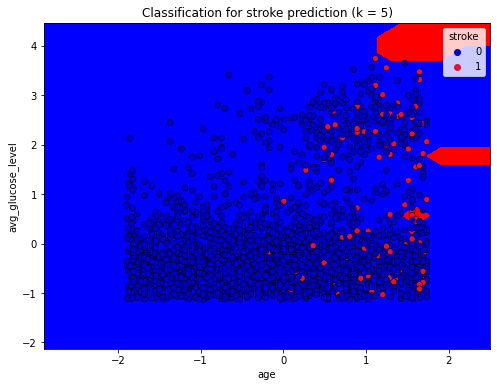

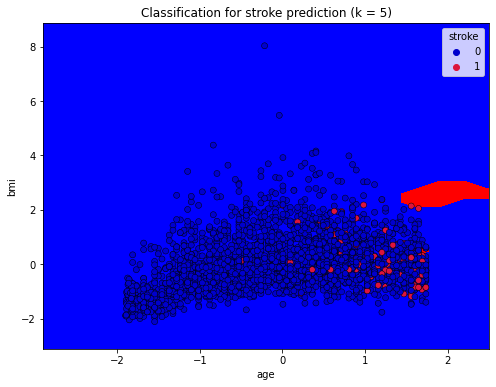

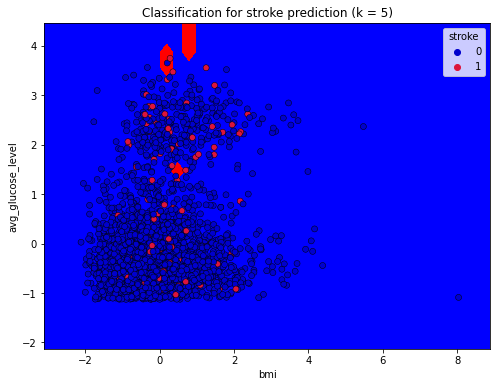

In [12]:
# Plot some features of the k-NN model, just mostly to get a feel for what the data looks like
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

def plot_knn(X, y, n_neighbors = 5):
    """
    This function plots a k Nearest Neighbours model with 2 features, using a meshgrid. Input is an X matrix with
    feature data and an y vector with class labels. It is possible to set the amount of neighbours that is looked at, default
    = 5.
    """

    # Code for plot by : https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
    # Step size in the mesh; determines how precise the patches are plotted
    h = 0.3  

    # Create color maps, colours equal to categories of output data
    cmap_light = ListedColormap(['blue', 'red'])
    # The colormap for the dots in the scatterplot
    cmap_bold = ['MediumBlue', 'Crimson']

    #Create an instance of Neighbours Classifier and fit the data.
    model = KNeighborsClassifier(n_neighbors, weights ='uniform') 
    model.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot the training points as well
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y,
                        palette=cmap_bold, alpha=1.0, edgecolor="black")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Classification for stroke prediction (k = {n_neighbors})")

    # Get the names of the x and y axis from the dataframe
    plt.xlabel(f"{X.iloc[:, 0].name}")
    plt.ylabel(f"{X.iloc[:, 1].name}")
    plt.show()

# Get two features with continues values to plot; for this we have age, bmi and average glucose level
# Plotting all the features would be too many dimensions, so plot 2 at a time
plot_knn(train_data[["age", "avg_glucose_level"]], train_labels)
plot_knn(train_data[["age", "bmi"]], train_labels)
plot_knn(train_data[["bmi", "avg_glucose_level"]], train_labels)